In [1]:
%load_ext autoreload
%autoreload 2
import os; import sys; sys.path.insert(0,'../')
import warnings
import pandas as pd
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

import socceraction.spadl.api as spadl
import tqdm
import requests
import math
import zipfile

In [2]:
datafolder = "../data"
statsbombzip = os.path.join(datafolder,"statsbomb-open-data.zip")
statsbombroot = os.path.join(datafolder,"statsbomb-root")
statsbombdata =  os.path.join(datafolder,"statsbomb-root","open-data-master","data")

In [3]:
# Create data folder if it doesn't exist
if not os.path.exists(datafolder):
    os.mkdir(datafolder)
    print(f"Directory {datafolder} created ")

In [4]:
url = "https://github.com/statsbomb/open-data/archive/master.zip"

# Streaming, so we can iterate over the response.
r = requests.get(url, stream=True)

# Total size in bytes.
total_size = int(r.headers.get("content-length", 0))
block_size = 1024 * 1024
wrote = 0
with open(statsbombzip, "wb") as f:
    datastream = tqdm.tqdm(
        r.iter_content(block_size),
        total=math.ceil(total_size // block_size),
        unit="MB",
        #unit_scale=True,
        #unit_divisor=1024
    )
    for data in datastream:
        wrote = wrote + len(data)
        f.write(data)
if total_size != 0 and wrote != total_size:
    print("ERROR, something went wrong")

12441MB [03:20, 61.92MB/s] 


In [5]:
with zipfile.ZipFile(statsbombzip, 'r') as zipObj:
    zipObj.extractall(statsbombroot)

os.listdir(statsbombdata)

['competitions.json', 'events', 'lineups', 'matches']

In [6]:
statsbomb_json =  os.path.join(datafolder,"statsbomb-root","open-data-master","data")
statsbomb_h5 = os.path.join(datafolder,"statsbomb.h5")
spadl_h5 = os.path.join(datafolder,"spadl-statsbomb.h5")

In [7]:
spadl.statsbombjson_to_statsbombh5(statsbomb_json,statsbomb_h5)

...Adding competitions to ../data\statsbomb.h5
...Adding matches to ../data\statsbomb.h5


...Adding players and teams to ../data\statsbomb.h5: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 643/643 [00:15<00:00, 41.18it/s]
converting events files to ../data\statsbomb.h5: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 643/643 [03:10<00:00,  2.05it/s]


In [8]:
tablenames = ["matches","players","teams","competitions"]
tables = {name : pd.read_hdf(statsbomb_h5,key=name) for name in tablenames}

match_id = tables["matches"].match_id[0]
tables["events"] = pd.read_hdf(statsbomb_h5,f"events/match_{match_id}")

for k,df in tables.items():
    print("#",k)
    print(df.columns,"\n")

# matches
Index(['away_score', 'away_team_gender', 'away_team_group', 'away_team_id',
       'away_team_name', 'competition_id', 'competition_name', 'country_name',
       'data_version', 'home_score', 'home_team_gender', 'home_team_group',
       'home_team_id', 'home_team_name', 'id', 'kick_off', 'last_updated',
       'managers', 'match_date', 'match_id', 'match_status', 'match_week',
       'name', 'season_id', 'season_name', 'shot_fidelity_version',
       'xy_fidelity_version'],
      dtype='object') 

# players
Index(['country_id', 'country_name', 'extra', 'jersey_number', 'player_id',
       'player_name', 'player_nickname'],
      dtype='object') 

# teams
Index(['team_id', 'team_name'], dtype='object') 

# competitions
Index(['competition_gender', 'competition_id', 'competition_name',
       'country_name', 'match_available', 'match_updated', 'season_id',
       'season_name'],
      dtype='object') 

# events
Index(['counterpress', 'duration', 'extra', 'id', 'index', 'locati

In [9]:
spadl.statsbombh5_to_spadlh5(statsbomb_h5,spadl_h5)

...Converting matches to games


HDF5ExtError: HDF5 error back trace

  File "C:\ci\hdf5_1545244154871\work\src\H5L.c", line 621, in H5Ldelete
    unable to delete link
  File "C:\ci\hdf5_1545244154871\work\src\H5L.c", line 2470, in H5L__delete
    unable to delete link: /games
  File "C:\ci\hdf5_1545244154871\work\src\H5L.c", line 2430, in H5L_delete
    can't unlink object
  File "C:\ci\hdf5_1545244154871\work\src\H5Gtraverse.c", line 851, in H5G_traverse
    internal path traversal failed
  File "C:\ci\hdf5_1545244154871\work\src\H5Gtraverse.c", line 627, in H5G__traverse_real
    traversal operator failed
  File "C:\ci\hdf5_1545244154871\work\src\H5L.c", line 2389, in H5L__delete_cb
    unable to remove link from group
  File "C:\ci\hdf5_1545244154871\work\src\H5Gobj.c", line 1009, in H5G_obj_remove
    can't remove object
  File "C:\ci\hdf5_1545244154871\work\src\H5Gstab.c", line 379, in H5G__stab_remove
    unable to remove entry
  File "C:\ci\hdf5_1545244154871\work\src\H5B.c", line 1587, in H5B_remove
    unable to remove entry from B-tree
  File "C:\ci\hdf5_1545244154871\work\src\H5B.c", line 1314, in H5B__remove_helper
    key not found in leaf node
  File "C:\ci\hdf5_1545244154871\work\src\H5Gnode.c", line 848, in H5G_node_remove
    unable to decrement object link count
  File "C:\ci\hdf5_1545244154871\work\src\H5Oint.c", line 994, in H5O_link
    unable to adjust object link count
  File "C:\ci\hdf5_1545244154871\work\src\H5Oint.c", line 877, in H5O__link_oh
    link count would be negative

End of HDF5 error back trace

problems deleting the node ``/games``

In [10]:
tablenames = ["games","players","teams","competitions","actiontypes","bodyparts","results"]
tables = {name : pd.read_hdf(spadl_h5,key=name) for name in tablenames}

game_id = tables["games"].game_id[0]
tables["actions"] = pd.read_hdf(spadl_h5,f"actions/game_{game_id}")

for k,df in tables.items():
    print("#",k)
    print(df.columns,"\n")

KeyError: 'No object named games in the file'

In [ ]:
import socceraction.classification.features as fs
import socceraction.classification.labels as lab

In [11]:
spadl_h5 = "spadl-statsbomb.h5"
features_h5 = "features.h5"
labels_h5 = "labels.h5"
predictions_h5 = "predictions.h5"

In [12]:
games = pd.read_hdf(spadl_h5,"games")

In [13]:
games = games[games.competition_name == "Women's World Cup"]
print("nb of games:", len(games))

actiontypes = pd.read_hdf(spadl_h5, "actiontypes")
bodyparts = pd.read_hdf(spadl_h5, "bodyparts")
results = pd.read_hdf(spadl_h5, "results")

nb of games: 52


In [14]:

xfns = [fs.actiontype,
       fs.actiontype_onehot,
       fs.bodypart,
       fs.bodypart_onehot,
       fs.result,
       fs.result_onehot,
       fs.goalscore,
       fs.startlocation,
       fs.endlocation,
       fs.movement,
       fs.space_delta,
       fs.startpolar,
       fs.endpolar,
       fs.team,
       fs.time,
       fs.time_delta
      ]

for game in tqdm.tqdm(list(games.itertuples()),desc=f"Generating and storing features in {features_h5}"):
    actions = pd.read_hdf(spadl_h5,f"actions/game_{game.game_id}")
    actions = (
        actions.merge(actiontypes,how="left")
        .merge(results,how="left")
        .merge(bodyparts,how="left")
        #.sort_values(["period_id", "time_seconds", "timestamp"])
        .reset_index(drop=True)
    )
    gamestates = fs.gamestates(actions,3)
    gamestates = fs.play_left_to_right(gamestates,game.home_team_id)
    
    X = pd.concat([fn(gamestates) for fn in xfns],axis=1)
    X.to_hdf(features_h5,f"game_{game.game_id}")

NameError: name 'fs' is not defined

In [ ]:
yfns = [lab.scores,lab.concedes,lab.goal_from_shot]

for game in tqdm.tqdm(list(games.itertuples()),desc=f"Computing and storing labels in {labels_h5}"):
    actions = pd.read_hdf(spadl_h5,f"actions/game_{game.game_id}")
    actions = (
        actions.merge(actiontypes,how="left")
        .merge(results,how="left")
        .merge(bodyparts,how="left")
        #.sort_values(["period_id", "time_seconds", "timestamp"])
        .reset_index(drop=True)
    )
    
    Y = pd.concat([fn(actions) for fn in yfns],axis=1)
    Y.to_hdf(labels_h5,f"game_{game.game_id}")

In [15]:
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

import socceraction.classification.features as fs
import socceraction.classification.labels as lab

In [16]:
# 1. Select feature set X
xfns = [fs.actiontype,
       fs.actiontype_onehot,
       #fs.bodypart,
       fs.bodypart_onehot,
       fs.result,
       fs.result_onehot,
       fs.goalscore,
       fs.startlocation,
       fs.endlocation,
       fs.movement,
       fs.space_delta,
       fs.startpolar,
       fs.endpolar,
       fs.team,
       #fs.time,
       fs.time_delta,
       #fs.actiontype_result_onehot
      ]
nb_prev_actions = 1

# generate the columns of the selected features
Xcols = fs.feature_column_names(xfns,nb_prev_actions)
X = []
for game_id in tqdm.tqdm(games.game_id,desc="selecting features"):
    Xi = pd.read_hdf(features_h5,f"game_{game_id}")
    X.append(Xi[Xcols])
X = pd.concat(X)

# 2. Select label Y
Ycols = ["scores","concedes"]
Y = []
for game_id in tqdm.tqdm(games.game_id,desc="selecting label"):
    Yi = pd.read_hdf(labels_h5,f"game_{game_id}")
    Y.append(Yi[Ycols])
Y = pd.concat(Y)
print("X:", list(X.columns))
print("Y:", list(Y.columns))

selecting label: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:00<00:00, 139.39it/s]


X: ['type_id_a0', 'type_pass_a0', 'type_cross_a0', 'type_throw_in_a0', 'type_freekick_crossed_a0', 'type_freekick_short_a0', 'type_corner_crossed_a0', 'type_corner_short_a0', 'type_take_on_a0', 'type_foul_a0', 'type_tackle_a0', 'type_interception_a0', 'type_shot_a0', 'type_shot_penalty_a0', 'type_shot_freekick_a0', 'type_keeper_save_a0', 'type_keeper_claim_a0', 'type_keeper_punch_a0', 'type_keeper_pick_up_a0', 'type_clearance_a0', 'type_bad_touch_a0', 'type_non_action_a0', 'type_dribble_a0', 'type_goalkick_a0', 'bodypart_foot_a0', 'bodypart_head_a0', 'bodypart_other_a0', 'result_id_a0', 'result_fail_a0', 'result_success_a0', 'result_offside_a0', 'result_owngoal_a0', 'result_yellow_card_a0', 'result_red_card_a0', 'goalscore_team', 'goalscore_opponent', 'goalscore_diff', 'start_x_a0', 'start_y_a0', 'end_x_a0', 'end_y_a0', 'dx_a0', 'dy_a0', 'movement_a0', 'start_dist_to_goal_a0', 'start_angle_to_goal_a0', 'end_dist_to_goal_a0', 'end_angle_to_goal_a0']
Y: ['scores', 'concedes']


In [17]:
%%time
# 3. train classifiers F(X) = Y
import xgboost

Y_hat = pd.DataFrame()
models = {}
for col in list(Y.columns):
    model = xgboost.XGBClassifier()
    model.fit(X,Y[col])
    models[col] = model

Wall time: 58.5 s


In [18]:
from sklearn.metrics import brier_score_loss, roc_auc_score

Y_hat = pd.DataFrame()
for col in Y.columns:
    Y_hat[col] = [p[1] for p in models[col].predict_proba(X)]
    print(f"Y: {col}")
    print(f"  Brier score: %.4f" % brier_score_loss(Y[col],Y_hat[col]))
    print(f"  ROC AUC: %.4f" % roc_auc_score(Y[col],Y_hat[col]))

Y: scores
  Brier score: 0.0100
  ROC AUC: 0.8446
Y: concedes
  Brier score: 0.0022
  ROC AUC: 0.9116


In [19]:

# get rows with game id per action
A = []
for game_id in tqdm.tqdm(games.game_id,"loading game ids"):
    Ai = pd.read_hdf(spadl_h5,f"actions/game_{game_id}")
    A.append(Ai[["game_id"]])
A = pd.concat(A)
A = A.reset_index(drop=True)

# concatenate action game id rows with predictions and save per game
grouped_predictions = pd.concat([A,Y_hat],axis=1).groupby("game_id")
for k,df in tqdm.tqdm(grouped_predictions,desc="saving predictions per game"):
    df = df.reset_index(drop=True)
    df[Y_hat.columns].to_hdf(predictions_h5,f"game_{int(k)}")

saving predictions per game: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:00<00:00, 59.66it/s]


In [20]:
import socceraction.vaep as vaep

In [21]:
players = pd.read_hdf(spadl_h5,"players")
teams = pd.read_hdf(spadl_h5,"teams")
actiontypes = pd.read_hdf(spadl_h5, "actiontypes")
bodyparts = pd.read_hdf(spadl_h5, "bodyparts")
results = pd.read_hdf(spadl_h5, "results")

A = []
for game in tqdm.tqdm(list(games.itertuples())):
    actions = pd.read_hdf(spadl_h5,f"actions/game_{game.game_id}")
    actions = (
        actions.merge(actiontypes)
        .merge(results)
        .merge(bodyparts)
        .merge(players,"left",on="player_id")
        .merge(teams,"left",on="team_id")
        .sort_values(["period_id", "time_seconds", "timestamp"])
        .reset_index(drop=True)
    )
    preds = pd.read_hdf(predictions_h5,f"game_{game.game_id}")
    values = vaep.value(actions,preds.scores,preds.concedes)
    A.append(pd.concat([actions,preds,values],axis=1))
A = pd.concat(A).sort_values(["game_id","period_id", "time_seconds", "timestamp"]).reset_index(drop=True)
A.columns

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:03<00:00, 15.84it/s]


Index(['game_id', 'period_id', 'time_seconds', 'timestamp', 'team_id',
       'player_id', 'start_x', 'start_y', 'end_x', 'end_y', 'type_id',
       'result_id', 'bodypart_id', 'action_id', 'type_name', 'result_name',
       'bodypart_name', 'country_id', 'country_name', 'extra', 'jersey_number',
       'player_name', 'player_nickname', 'team_name', 'scores', 'concedes',
       'offensive_value', 'defensive_value', 'vaep_value'],
      dtype='object')

In [22]:

A["player"] = A[["player_nickname","player_name"]].apply(lambda x: x[0] if x[0] else x[1],axis=1)

A["count"] = 1

A_ = A[A.type_name != "shot_penalty"] # ignore penalties
players = (
    A_[["player_id","team_name","player","vaep_value","count"]]
    .groupby(["player_id","team_name","player"])
    .sum()
    .reset_index()
)
players = players.sort_values("vaep_value",ascending=False)
players

,player_id,team_name,player,vaep_value,count
175,15623,Netherlands Women's,Vivianne Miedema,5.257158,493
43,5085,United States Women's,Alex Morgan,4.875153,345
335,25673,Thailand Women's,Suchawadee Nildhamrong,4.418277,201
13,4999,United States Women's,Lindsey Horan,3.920984,530
6,4961,Australia Women's,Samantha Kerr,3.909881,284
55,8298,United States Women's,Megan Rapinoe,3.897321,554
62,10125,France Women's,Wendie Renard,3.697266,602
61,10123,France Women's,Amandine Henry,3.637705,527
102,10220,Sweden Women's,Kosovare Asllani,3.631487,615
81,10178,England Women's,Lucy Bronze,3.575012,1078


In [23]:

pg = pd.read_hdf(spadl_h5,"player_games")
pg = pg[pg.game_id.isin(games.game_id)]
mp = pg[["player_id","minutes_played"]].groupby("player_id").sum().reset_index()
stats = players.merge(mp)
stats = stats[stats.minutes_played > 150]
stats["vaep_rating"] = stats.vaep_value * 90 / stats.minutes_played
stats.sort_values("vaep_value",ascending=False)

,player_id,team_name,player,vaep_value,count,minutes_played,vaep_rating
0,15623,Netherlands Women's,Vivianne Miedema,5.257158,493,683,0.692744
1,5085,United States Women's,Alex Morgan,4.875153,345,510,0.860321
2,25673,Thailand Women's,Suchawadee Nildhamrong,4.418277,201,283,1.405106
3,4999,United States Women's,Lindsey Horan,3.920984,530,388,0.909507
4,4961,Australia Women's,Samantha Kerr,3.909881,284,408,0.862474
5,8298,United States Women's,Megan Rapinoe,3.897321,554,434,0.808200
6,10125,France Women's,Wendie Renard,3.697266,602,504,0.660226
7,10123,France Women's,Amandine Henry,3.637705,527,504,0.649590
8,10220,Sweden Women's,Kosovare Asllani,3.631487,615,636,0.513890
9,10178,England Women's,Lucy Bronze,3.575012,1078,667,0.482385


In [ ]:
final = A.loc[A['game_id'] == 69321]
final = final[~(final['vaep_value'] <= -0.25)] 
final = final[~(final['vaep_value'] >= 0.25)] 

In [ ]:
final['vaep_value'] += abs(final['vaep_value'].min())

In [ ]:
final.plot(y = 'vaep_value')

In [ ]:
A['vaep_value'].min()

In [24]:
A.to_csv('VAEP.csv')

In [26]:
stats.to_csv('VAEP_Players.csv')

In [28]:
labels = stats['team_name'].unique()

In [31]:
x = stats.groupby(['team_name'])['vaep_rating'].sum()

In [36]:
labels.sort()

In [68]:
explode = (0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05)

In [42]:
import matplotlib.pyplot as plt

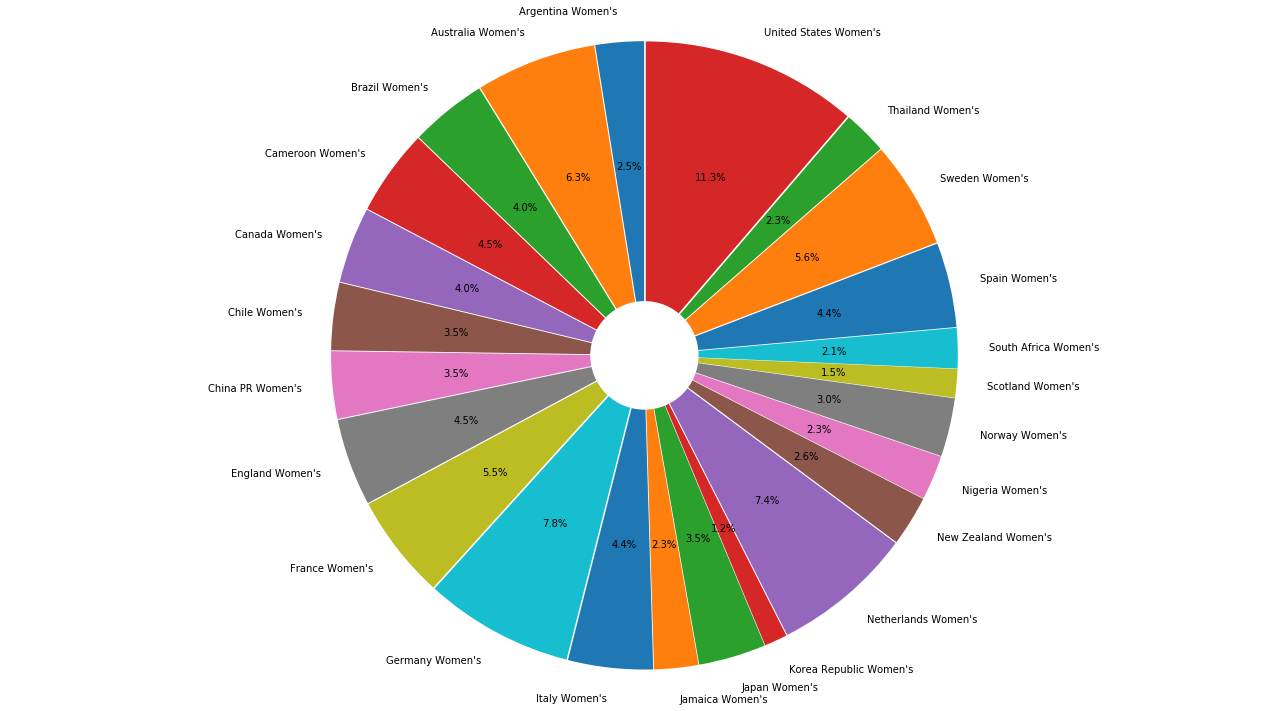

In [72]:
fig1, ax1 = plt.subplots(figsize=(18, 10))
ax1.pie(x, labels=labels, autopct='%1.1f%%',radius = 4, startangle=90, explode = explode)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
# plt.title('Fraction of total value of actions performed by teams', fontsize = 19, fontweight="bold")
plt.savefig('abc.png', dpi = 1000)#, facecolor = '#668b8b')

In [67]:
len(explode)

20